In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')

### Preprocessing

1. Read the data

2. Calculate normalized qualification score: (math+reading+writng)/300

In [2]:
Exams = pd.read_csv('exams.csv')
Exams = Exams[Exams['gender'] == 'male']

In [3]:
Exams['Qscore'] = (Exams['math score'] + Exams['reading score'] + Exams['writing score'])/300

In [4]:
Exams

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Qscore
0,male,group A,high school,standard,completed,67,67,63,0.656667
2,male,group E,some college,free/reduced,none,59,60,50,0.563333
3,male,group B,high school,standard,none,77,78,68,0.743333
4,male,group E,associate's degree,standard,completed,78,73,68,0.730000
7,male,group E,some college,standard,completed,93,88,84,0.883333
...,...,...,...,...,...,...,...,...,...
992,male,group C,some college,standard,none,69,63,66,0.660000
994,male,group E,high school,free/reduced,completed,86,82,75,0.810000
995,male,group C,high school,standard,none,73,70,65,0.693333
996,male,group D,associate's degree,free/reduced,completed,85,91,92,0.893333


### Fit the distribution

We try to fit the qualification score by a beta distribution

Because the maximum of Qscore is 1.0, we fix loc = 0 and scale = 1+1e-8 (slightly larger than 1.0) to avoid error

In [5]:
import scipy.integrate as integrate
from scipy.stats import uniform, beta
Qscore = Exams['Qscore']
a, b, loc, scale = beta.fit(Qscore, floc = 0 ,fscale = 1+1e-8)

In [6]:
a,b,loc,scale

(4.864021228209696, 2.365628260721473, 0, 1.00000001)

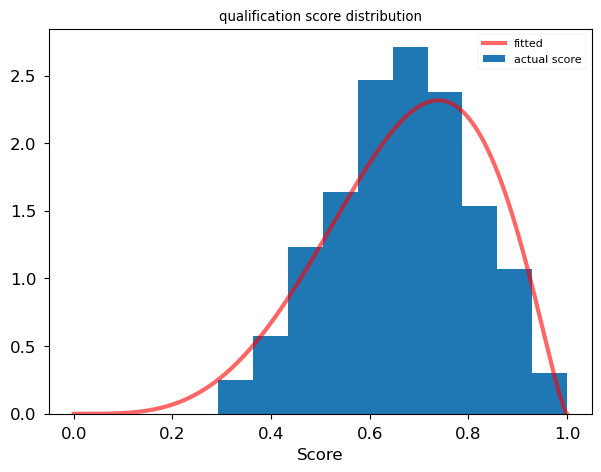

In [7]:
# Visualize the distribution
x = np.linspace(0,1,1000)
plt.figure(figsize = (7,5))
plt.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=3, alpha=0.6, label = 'fitted')
plt.hist(Qscore, label = 'actual score',density=True)
plt.title('qualification score distribution')
plt.xlabel('Score', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.savefig('score_exam_male.pdf')

###  Decision Maker to incentivize improvement

In [8]:
threshold = 0.316364
def compute_decision_benefit_strategic(r, theta):
    # lower bound for improvement to begin
    if theta == 0 or theta == 1:
        xstar = theta
    else:
        xstar = (1 + (1/theta**(2)-1) * np.exp(2*threshold/np.log(1+r)))**(-0.5)

    result = integrate.quad(lambda x: (theta-x)*beta.pdf(x,a,b,loc,scale), xstar, theta)[0]
    return result

def maximize_one_decision_benefit_strategic(r):
    theta = np.linspace(0.0001,1,10000)
    myFn = np.vectorize(compute_decision_benefit_strategic, excluded=['r'])
    benefit = myFn(r,theta)
    df = pd.DataFrame({'theta':theta, 'benefit':benefit})
    max_benefit = df.max()['benefit']
    max_theta = df[df['benefit'] == max_benefit]['theta'].item()
    min_improve = (1 + (1/max_theta**(2)-1) * np.exp(2*threshold/np.log(1+r)))**(-0.5)
    max_percentage = 1-beta.cdf(min_improve,a,b,loc,scale)
    print('Strategic threshold is %f and the max benefit is %f' %(max_theta, max_benefit))
    print('Finally, qualified population percentage will be: %.2f%%' % (100*max_percentage))
#     return max_theta, max_benefit

In [31]:
maximize_one_decision_benefit_strategic(0.3)

Strategic threshold is 0.873600 and the max benefit is 0.141997
Finally, qualified population percentage will be: 87.17%


**This means when considering improvement, the decision maker can have both higher threshold and higher maximum utility**

### Varying r and ploting:

1. the optimal strategic threshold

2. the total improvement amount

It is reasonable to varying r from 0 to 0.3 to see the threshold change

In [9]:
def produce_threshold_dataframe(r_list, maximize_func):
    best_threshold = {'r':[],'optimal theta':[],'qualified percentage':[],'optimal utility':[]}
    for r in r_list:
        theta = np.linspace(0.0001,1,10000)
        benefit = maximize_func(r,theta)
        df = pd.DataFrame({'theta':theta, 'benefit':benefit})
        max_benefit = df.max()['benefit']
        max_theta = df[df['benefit'] == max_benefit]['theta'].item()
        min_improve = (1 + (1/max_theta**(2)-1) * np.exp(2*threshold/np.log(1+r)))**(-0.5)
        max_percentage = 1-beta.cdf(min_improve,a,b,loc,scale)
        best_threshold['r'].append(r)
        best_threshold['optimal theta'].append(max_theta)
        best_threshold['qualified percentage'].append(np.round(100*max_percentage, 4))
        best_threshold['optimal utility'].append(max_benefit)
    return pd.DataFrame(best_threshold)

In [10]:
r_list = np.linspace(0,0.3,7)
r_list = r_list[1:]
maximize_func = np.vectorize(compute_decision_benefit_strategic, excluded=['r'])
exam_res = produce_threshold_dataframe(r_list, maximize_func)

In [11]:
exam_res.to_csv('exam_male.csv')
exam_res

,r,optimal theta,qualified percentage,optimal utility
0,0.05,0.9998,99.9968,0.326982
1,0.10,0.9892,99.3501,0.311250
2,0.15,0.9598,96.9846,0.266424
3,0.20,0.9267,93.6491,0.216396
4,0.25,0.8976,90.2447,0.174383
5,0.30,0.8736,87.1685,0.141997


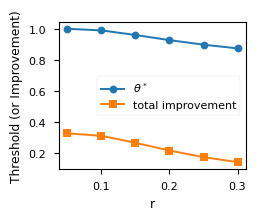

In [13]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20.7})
fig, axes = plt.subplots(1, 1, figsize = (3,2.5))
plt.tight_layout
plt.plot(exam_res['r'], exam_res['optimal theta'], marker='o', label = r'$\theta^*$')
plt.plot(exam_res['r'], exam_res['optimal utility'], marker = 's', label = 'total improvement')
plt.xlabel('r')
plt.ylabel('Threshold (or Improvement)')
plt.legend()
plt.tight_layout()
fig.savefig('threshold_exam_male.pdf')

### Plot the percentage of population who manipulates under the strategic optimal threshold

In [14]:
def get_manipulation_percentage(theta_list, r_list, prob = [0.1,0.2,0.3,0.4,0.5]):
    final_res = {}
    violate = False
    for p in prob:
        manip_res = {'r':[],'optimal theta':[],'manipulation percentage':[]}
        for i in range(len(theta_list)):
            theta = theta_list[i]
            r = r_list[i]
            x = np.linspace(0,theta,1000)
            A = -np.log(np.sqrt((1/theta**2-1)/(1/x**2-1)))*np.log(1+r)
            T = -np.log(np.sqrt((1/theta**2-1)/(1/x**2-1)))/np.log(2)
            manip_res['r'].append(np.round(r,2))
            manip_res['optimal theta'].append(np.round(theta,2))
            y1 = (1-p) * 1/(1+r)**T - (theta - x)
            y2 = np.zeros(1000)
            i = 0
            for A_value in A:
                func = lambda tau: -np.exp(-A_value/tau) + np.exp(tau) - 1
                res = scipy.optimize.minimize_scalar(func, bounds= [0,1], method='bounded')
                y2[i] = max(-func(res.x),0)
                i += 1
            df = pd.DataFrame({'x0': x, 'net': y1-y2})
            if(len(df[df['net'] >= 0]) == 0):
                manip_res['manipulation percentage'].append(0)
            else:
                target_df = df[df['net']>0]
                i = 0
                percentage = 0
                left = target_df.iloc[0]['x0'] 
                while i < len(target_df):
                    if i == len(target_df) - 1 or target_df.iloc[i+1]['x0'] - target_df.iloc[i]['x0'] > theta/900:
                        right = target_df.iloc[i]['x0']
                        percentage += (beta.cdf(right,a,b,loc,scale) - beta.cdf(left,a,b,loc,scale))/(beta.cdf(theta,a,b,loc,scale))
                        if i != len(target_df) - 1:
                            violate = True
                            left = target_df.iloc[i+1]['x0']
                    i += 1
                manip_res['manipulation percentage'].append(np.round(100*percentage,4))
        if p not in final_res.keys():
            final_res[p] = manip_res
        if violate == True:
            print('theta = %f does not exceed theta bar' %(theta))
    return final_res


In [34]:
theta_list = exam_res['optimal theta']
r_list = exam_res['r']
manip_result = get_manipulation_percentage(theta_list, r_list, prob = [0.1,0.3,0.4,0.6])

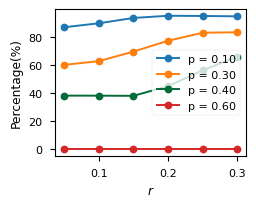

In [36]:
plt.figure(figsize=(3,2.5))
prob = [0.1,0.3,0.4,0.6]
color = ['#1f77b4', '#ff7f0e', '#046a38', '#d62728', '#9467bd']
i = 0
for p in prob:
    target1 = manip_result[p]
    plt.plot(target1['r'], target1['manipulation percentage'], marker='o', label = 'p = %.2f'%p, color = color[i])
    plt.xlabel(r'$r$')
    plt.ylabel('Percentage(%)')
    plt.legend()
    i += 1
plt.tight_layout()
plt.savefig('manipulation_percent_exam_male.pdf')